<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 3 / NOTE 2*

---

# Interpretable ML - II

## 🏆 학습목표
1. Individual Conditional Expectation(ICE) plot의 원리를 이해하고 시각화, 해석할 수 있다.
2. Partial Dependence Plot(PDP)의 원리를 이해하고 `pdpbox` 라이브러리를 사용해 시각화, 해석할 수 있다.
3. 다양한 ML모델 해석 방법을 여러 기준에 따라 분류하고 필요에 따라 적절히 사용할 수 있다.


### Warm up

#### 다음 동영상을 시청하세요.
- [Partial Dependence Plot (PDP) in Python](https://www.youtube.com/watch?v=21QAKe2PDkk)
    - model-agnostic 방법이 무엇인가요?

#### 학습을 진행하기 전에 다음 페이지를 읽어 보세요.
- [Kaggle: Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)

### 📚 아래 라이브러리를 설치해 주세요.

#### 이번 모듈에서 추가적으로 사용하는 라이브러리는 다음과 같습니다. 설치를 확인해 주세요.
- [**pdpbox**](https://github.com/SauceCat/PDPbox)

In [1]:
!pip install category_encoders
!pip3 install pdpbox
!pip3 install xgboost==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.0/34.0 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=d82d5d441278045bdbc4bd21fd46d107990a18d94d8340d754de25a22e76a0df
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=12090138 sha256=15191a943ee10a85a7ebebfc0ea4f1c7f54b50554f41e456eb74dc77809b1ec3
  Stored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


# 1. Individual Conditional Expectation(ICE) plot
- 이전 노트에서 배운 특성 중요도들은 각 특성이 예측 성능에 **얼마나** 영향을 주는지 쉽게 파악할 수 있게 해주므로 유용하게 사용됩니다. 
- 하지만 각 특성이 증가/감소할 때 모델의 예측값이 어떻게 변하는지와 같이 모델의 예측에 **어떻게** 영향을 주는지 알 수 없습니다.
- Individual Conditional Expectation(ICE) plot을 사용하면 특정 관측치에 대해, 특정 특성의 값을 변화시킬 때 모델의 예측 양상이 어떻게 변하는지 파악할 수 있습니다.

### 💰 Case Study: Census Income DataSet
- 사람들의 개인 특성 정보를 기반으로 연봉이 $50K를 초과하는지 분류해 봅시다. 
- 데이터셋은 1994년 미국 인구조사에 참여한 사람들의 아래 정보로 구성되어 있습니다.

#### 범주형 특성
*   `workclass`: 고용 형태
*   `education`: 최종 학력
*   `marital-status`: 결혼 여부
*   `occupation`: 직업
*   `relationship`: 가정 내 개인의 관계
*   `race`: 인종
*   `sex`: 성별
*   `native-country`: 출신 국가


#### 수치형 특성
*   `age`: 나이
*   `capital_gain`: 개인의 자본 이익($)
*   `capital_loss`: 개인의 자본 손실($)
*   `hours_per_week`: 주당 근무시간

#### 예측 타겟
*   `salary`: 개인의 연 소득이 $50K를 초과하는지 여부

- 데이터셋에 대한 세부 정보는 [여기](https://archive.ics.uci.edu/ml/datasets/Census+Income)를 참조하세요.

In [2]:
# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import linalg

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import matplotlib.font_manager as fm
from matplotlib.ticker import LinearLocator

# scipy
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.misc import derivative
from scipy.stats.distributions import uniform

# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

# scikit-learn
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, plot_confusion_matrix, confusion_matrix, \
  classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# others
import graphviz
from xgboost import XGBClassifier, XGBRegressor
import re
import math
import seaborn as sns
# from category_encoders import OrdinalEncoder

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/census_income.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
data.salary.unique()

array([' <=50K', ' >50K'], dtype=object)

In [6]:
# 어떤 특성이 있나요?
data.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
salary                2
dtype: int64

In [7]:
# 결측치가 있는 row를 drop하고 salary를 범주형으로 변환합니다.
data = data.replace(" ?", np.nan).dropna().reset_index(drop=True)
print("salary before preprocessing", data["salary"].unique())
data["salary"] = data["salary"].str.strip().apply(lambda x: x == ">50K")    # 타겟 : 50K 초과 (1) , 50K 이하 (0)
print("salary after preprocessing", data["salary"].unique())

salary before preprocessing [' <=50K' ' >50K']
salary after preprocessing [False  True]


### 타겟의 최빈값으로 예측하는 baseline 모델의 성능을 확인합니다.

In [8]:
baseline_score = data["salary"].value_counts(normalize=True).max()
print("baseline score:", baseline_score)

baseline score: 0.7510775147536636


In [9]:
from sklearn.model_selection import train_test_split

# 학습과 검증 데이터셋을 분리합니다.
train, val = train_test_split(data, test_size=0.2, random_state=42)

# 사용할 특성 및 타겟을 선택합니다.
cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
num_featuers = ["age", "capital-gain", "capital-loss", "hours-per-week"]
target = "salary"

# 특성과 타겟을 분리합니다.
X_train = train[cat_features + num_featuers]
y_train = train[target]
X_val = val[cat_features + num_featuers]
y_val = val[target]

### XGBoost 라이브러리를 사용해 Gradient Boosting Decision Tree Classifier로 데이터를 모델링합니다.
- GBDT는 DT의 특성을 그대로 지니기 때문에, `OneHotEncoding` 대신 `OrdinalEncoding`을 사용합니다.
- early_stopping 기능을 사용해, 50회까지 검증 데이터셋의 성능 향상이 없으면 종료합니다.

In [10]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)  # 학습데이터
X_val_encoded = encoder.transform(X_val)  # 검증데이터

boosting = XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # default
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-logloss:0.59605	validation_1-logloss:0.59734
[1]	validation_0-logloss:0.53264	validation_1-logloss:0.53587
[2]	validation_0-logloss:0.48905	validation_1-logloss:0.49323
[3]	validation_0-logloss:0.45107	validation_1-logloss:0.45628
[4]	validation_0-logloss:0.41957	validation_1-logloss:0.42501


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.39525	validation_1-logloss:0.40076
[6]	validation_0-logloss:0.37804	validation_1-logloss:0.38431
[7]	validation_0-logloss:0.36226	validation_1-logloss:0.36801
[8]	validation_0-logloss:0.35093	validation_1-logloss:0.35749
[9]	validation_0-logloss:0.34069	validation_1-logloss:0.34791
[10]	validation_0-logloss:0.33333	validation_1-logloss:0.34154
[11]	validation_0-logloss:0.32630	validation_1-logloss:0.33488
[12]	validation_0-logloss:0.32071	validation_1-logloss:0.32902
[13]	validation_0-logloss:0.31591	validation_1-logloss:0.32484
[14]	validation_0-logloss:0.31169	validation_1-logloss:0.32103
[15]	validation_0-logloss:0.30849	validation_1-logloss:0.31803
[16]	validation_0-logloss:0.30604	validation_1-logloss:0.31590
[17]	validation_0-logloss:0.30346	validation_1-logloss:0.31392
[18]	validation_0-logloss:0.30058	validation_1-logloss:0.31110
[19]	validation_0-logloss:0.29709	validation_1-logloss:0.30784
[20]	validation_0-logloss:0.29437	validation_1-logloss:0.306

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### 검증 데이터에 대한 성능을 확인해 볼까요?

In [ ]:
y_pred_proba = boosting.predict_proba(
    X_val_encoded, iteration_range=(0, boosting.best_iteration)
)[:, 1]
y_pred = boosting.predict(X_val_encoded, iteration_range=(0, boosting.best_iteration))
print("검증 accuracy", boosting.score(X_val_encoded, y_val))
print("검증 AUC", roc_auc_score(y_val, y_pred_proba))
print(classification_report(y_val, y_pred))

검증 accuracy 0.8710425990386209
검증 AUC 0.9283238189790683
              precision    recall  f1-score   support

       False       0.89      0.94      0.92      4503
        True       0.79      0.67      0.72      1530

    accuracy                           0.87      6033
   macro avg       0.84      0.80      0.82      6033
weighted avg       0.87      0.87      0.87      6033



### ICE plot을 사용하면 **특정 관측치**(데이터포인트)에서의 **특정 특성**의 변화에 따른 모델의 예측 양상 변화를 확인할 수 있습니다.
- 검증 데이터셋의 세 번째 데이터에 대해 분석해 봅시다.

In [ ]:
X_val.iloc[[3]]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week
12484,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,31,0,0,45


- 위와 같은 인구통계 정보를 갖는 사람에 대해, 나이가 바뀔수록 모델이 어떻게 예측을 달리하는지 봅시다.

In [ ]:
# 예측 양상의 변화를 확인하고자 하는 데이터를 가져옵니다.
one_datapoint = X_val_encoded.iloc[[3]].copy()

# 세 번째 데이터의 age 값을 데이터셋에 존재하는 최소 나이에서 최대 나이까지의 age값으로 바꿔볼 것입니다.
age_test_range = range(X_val_encoded["age"].min(), X_val_encoded["age"].max() + 1)

results = []

for age in age_test_range:
    one_datapoint["age"] = age  # age값을 바꿔넣어 봅니다.
    one_datapoint_pred_proba = boosting.predict_proba(one_datapoint)[
        :, 1
    ]  # 모델이 age가 바뀐 데이터로부터 확률을 예측합니다.
    results.append(one_datapoint_pred_proba.item())  # 각 확률을 리스트에 담아 둡니다.
results = np.array(results)
results -= results[0]  # 나이가 최소일 때 모델 예측 확률로부터의 변화값을 볼 것입니다.

Text(0, 0.5, '$\\Delta$ pred_proba')

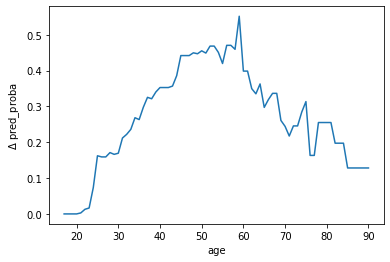

In [ ]:
import matplotlib.pyplot as plt

plt.plot(age_test_range, results)
plt.xlabel("age")
plt.ylabel("$\Delta$ pred_proba")

- 위 정보를 갖는 사람들에 대해, 모델은 나이가 60에 이르기까지 꾸준히 연봉이 $50K를 초과할 확률이 증가할 것이라 분석합니다.
- 그런데, 다른 특성을 갖는 사람들에 대해서도 모델이 위와 같이 분석할까요? 확인해 봅시다.

In [ ]:
# 데이터셋(data), 분석할 데이터의 index(data_index), 변화를 확인할 특성명(target_feature), 바꿔넣어 볼 특성의 범위(target_feature_range)를 입력하면
# 해당 범위에서 모델의 예측 양상의 변화를 반환하는 함수를 작성합니다.
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = boosting.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

- 0번, 10번, 129번, 2022번 데이터에 대해 동일한 작업을 수행하고 시각화합니다.

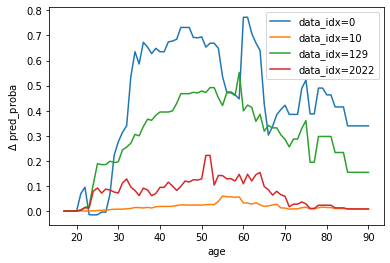

In [ ]:
target_feature = "age"
target_feature_range = range(X_val_encoded["age"].min(), X_val_encoded["age"].max() + 1)
for data_index in [0, 10, 129, 2022]:
    plt.plot(
        *get_ice_plot_data(
            X_val_encoded, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

- 사람들의 인구통계학적 특성이 달라지면 모델은 연 수입에 대한 나이의 영향력을 각기 다르게 평가합니다.
  - 0번과 10번 데이터는 꽤 극적인 차이가 나네요. education, occupation 등의 특성들이 다른 값을 갖기 때문에 모델은 연 수입에 대한 나이의 영향력을 다르게 판단합니다.
  - pred_proba = 1로 예측할 확률값

In [ ]:
X_val.iloc[[0, 10]]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week
217,Private,Prof-school,Never-married,Prof-specialty,Not-in-family,White,Male,United-States,28,0,0,55
21957,Private,HS-grad,Never-married,Exec-managerial,Own-child,White,Female,United-States,22,0,0,40


# 2. Partial Dependence Plot (PDP)
- ICE plot을 사용하면 특정 데이터에 대해 특성의 변화에 따른 모델의 예측 양상 변화를 살펴볼 수 있었습니다.
- 하지만 하나의 ICE plot을 그려본 후, 모델이 해당 특성에 대해 전반적으로 어떻게 분석하고 이해하고 있는지 판단할 수 없습니다.
  - 위 예시에서도 확인한 것처럼, 다른 인구통계학적 특성을 가진 사람들에게 모델은 age 특성의 영향력을 꽤나 다르게 평가합니다.
- 어떻게 하면 모델의 해당 특성에 대한 전반적인 이해 방식을 살펴볼 수 있을까요?

### 사람들은 각기 서로 다른 특성을 가지고 있지만, **평균적으로** 모델이 나이의 변화에 따라 연 수입을 어떻게 예측하는지 궁금합니다
- 여러 세세한 조건에서의 모델의 예측 변화를 확인하기는 어렵지만, PDP를 통해 전반적인 모델의 해당 특성에 대한 이해 방식을 확인할 수 있습니다.
- **PDP는 입력 데이터들에 대한 ICE plot의 평균으로 구할 수 있습니다.**

### 우리가 작성한 함수를 사용해 검증 데이터셋에 데이터에 대한 PDP(평균-ICE plot)를 그려 봅시다.
- *Note) 시간이 꽤 오래 걸립니다!*

In [ ]:
from tqdm import tqdm

target_feature = "age"
target_feature_range = [20, 30, 40, 50, 60, 70, 80]

all_ice_plot_data = []

# 모든 검증 데이터에 대해 우리가 작성한 함수로 ICE plot 데이터를 계산합니다.
for data_index in tqdm(range(len(X_val_encoded))):
    all_ice_plot_data.append(
        get_ice_plot_data(
            X_val_encoded, data_index, target_feature, target_feature_range
        )[1]
    )

100%|██████████| 6033/6033 [01:52<00:00, 53.45it/s]


(6033, 7)
(7,)


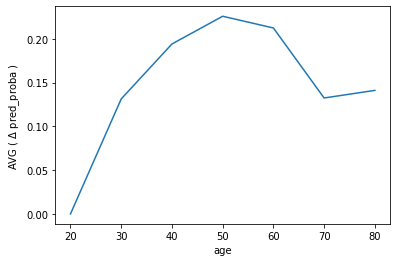

In [ ]:
all_ice_plot_data = np.array(all_ice_plot_data)
print(all_ice_plot_data.shape)

# 6033개의 ICE plot data를 0번째(data index) 축으로 평균합시다.
pdp_data = all_ice_plot_data.mean(0)
print(pdp_data.shape)

# PDP(평균 ICE plot) data를 시각화해 봅시다.
plt.plot(target_feature_range, pdp_data)
plt.xlabel(target_feature)
plt.ylabel("AVG ( $\Delta$ pred_proba ) ")
plt.show()

- 모델은 **평균적**으로 
  - **20대 초반**에 비해 **50대**에서 
  - **연 수입이 $50K를 초과할 확률**이 
- **24%p가량 상승**한다고 예측합니다. 

### PDP의 해석 시 유의할 점
- PDP는 특정 특성에 대한 모델의 복잡한 반응 양상을 이해하기 쉽게 시각화해 준다는 장점이 있습니다.
- 하지만 해석 시 몇몇 주의할 점이 있습니다.
#### 1. PDP는 각 특성 간의 독립성을 전제로 합니다.
- 즉, 위의 예시에서는 서로 다른 workclass, education 등의 값을 갖는 샘플 집단에 대해 age가 동일하게 분포하고 있다고 가정합니다.
- 하지만 만약 서로 강한 상관관계가 있는 경우에는 비현실적인 데이터(전제)로 값을 예측하게 됩니다. 예를 들어, 17세에 대학원 졸업 학력을 갖는 사람은 거의 없지만, PDP 계산 과정에서는 해당 데이터를 모델에게 예측 입력으로 제공하게 됩니다.
- 또한 이 경우에는 해석에 유의할 필요가 있습니다. 
    - 예를 들어, 높은 교육수준을 갖는 집단의 나이가 타 집단에 비해 큰 값을 갖는다면, 나이에 대한 PDP 곡선이 온전히 나이 특성에 의한 것인지 교육 수준의 차이에 의한 것인지 구분할 수 없습니다.

  #### 2. PDP를 해석할 때는 살펴보고자 하는 특성값의 분포를 주의 깊게 살펴보아야 합니다.
- PDP는 실제 해당 특성값을 갖는 데이터가 존재하든 존재하지 않든 특성값을 넣어서 모델의 예측값을 확인합니다. 예를 들어, PDP는 학습 데이터나 평가 데이터에 나이가 60~70세 사이인 데이터가 존재하는지 여부와 관계 없이 해당 값을 대입해서 모델의 예측값 변화를 살펴봅니다.
- 하지만 모델이 학습 과정에서 해당 특성값을 갖는 데이터를 학습하지 못했다면, 모델은 해당 구간에서 이상한 예측값을 낼 수 있습니다. 
- 따라서, 실제 데이터 분포에서 특정 값 지점(또는 구간)을 갖는 데이터가 많이 없을 경우, 해당 구간에 대한 PDP의 해석은 조심스럽게 접근해야 합니다.

### PDP를 손쉽게 그려 주는 `pdpbox` 라이브러리를 이용해 봅시다.
- `pdpbox` 라이브러리의 `pdp_isolate`을 사용하면 하나의 특성에 대한 PDP를 시각화할 수 있습니다.
  - `grid_type`
    - `percentile`: 특성의 분포에 따라 특성값 지점을 선택할 수 있습니다.
    - `equal`: 동일한 간격으로 특성값 지점을 선택할 수 있습니다.
  - `num_grid_points`: 몇 개의 특성값 지점을 선택하여 모델의 변화 양상을 확인해볼 것인지 선택할 수 있습니다.
- 자세한 설명은 [공식 문서](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html#pdpbox-pdp-pdp-isolate)를 참고하세요.

In [ ]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f69926e65e0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6992619910>})

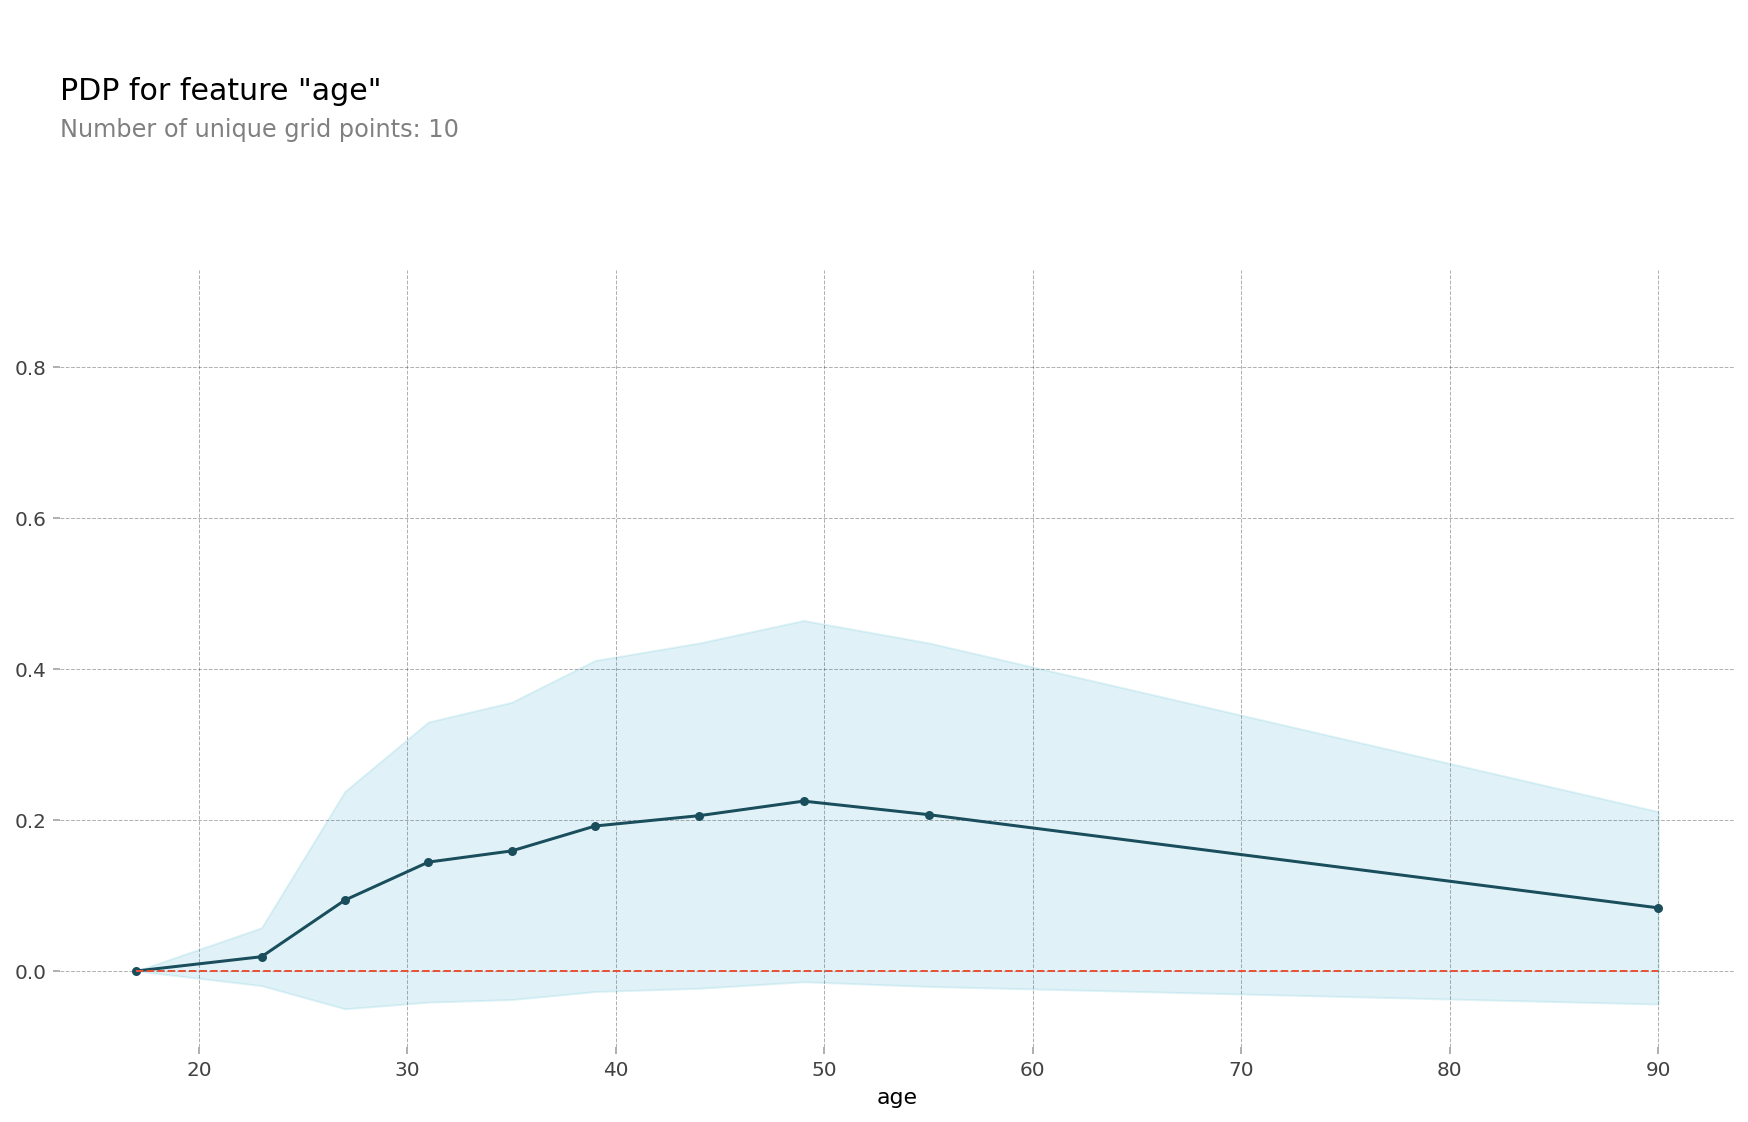

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "age"

isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

In [ ]:
# y축이 나타내는 것
# 예측 확률값의 변화량 p(k)-p(min) (k:age)

### `pdp_plot`을 사용해 PDP 를 50개의 ICE plot과 함께 그려봅시다.

(<Figure size 2160x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6992591cd0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6990d54070>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6990cfd460>}})

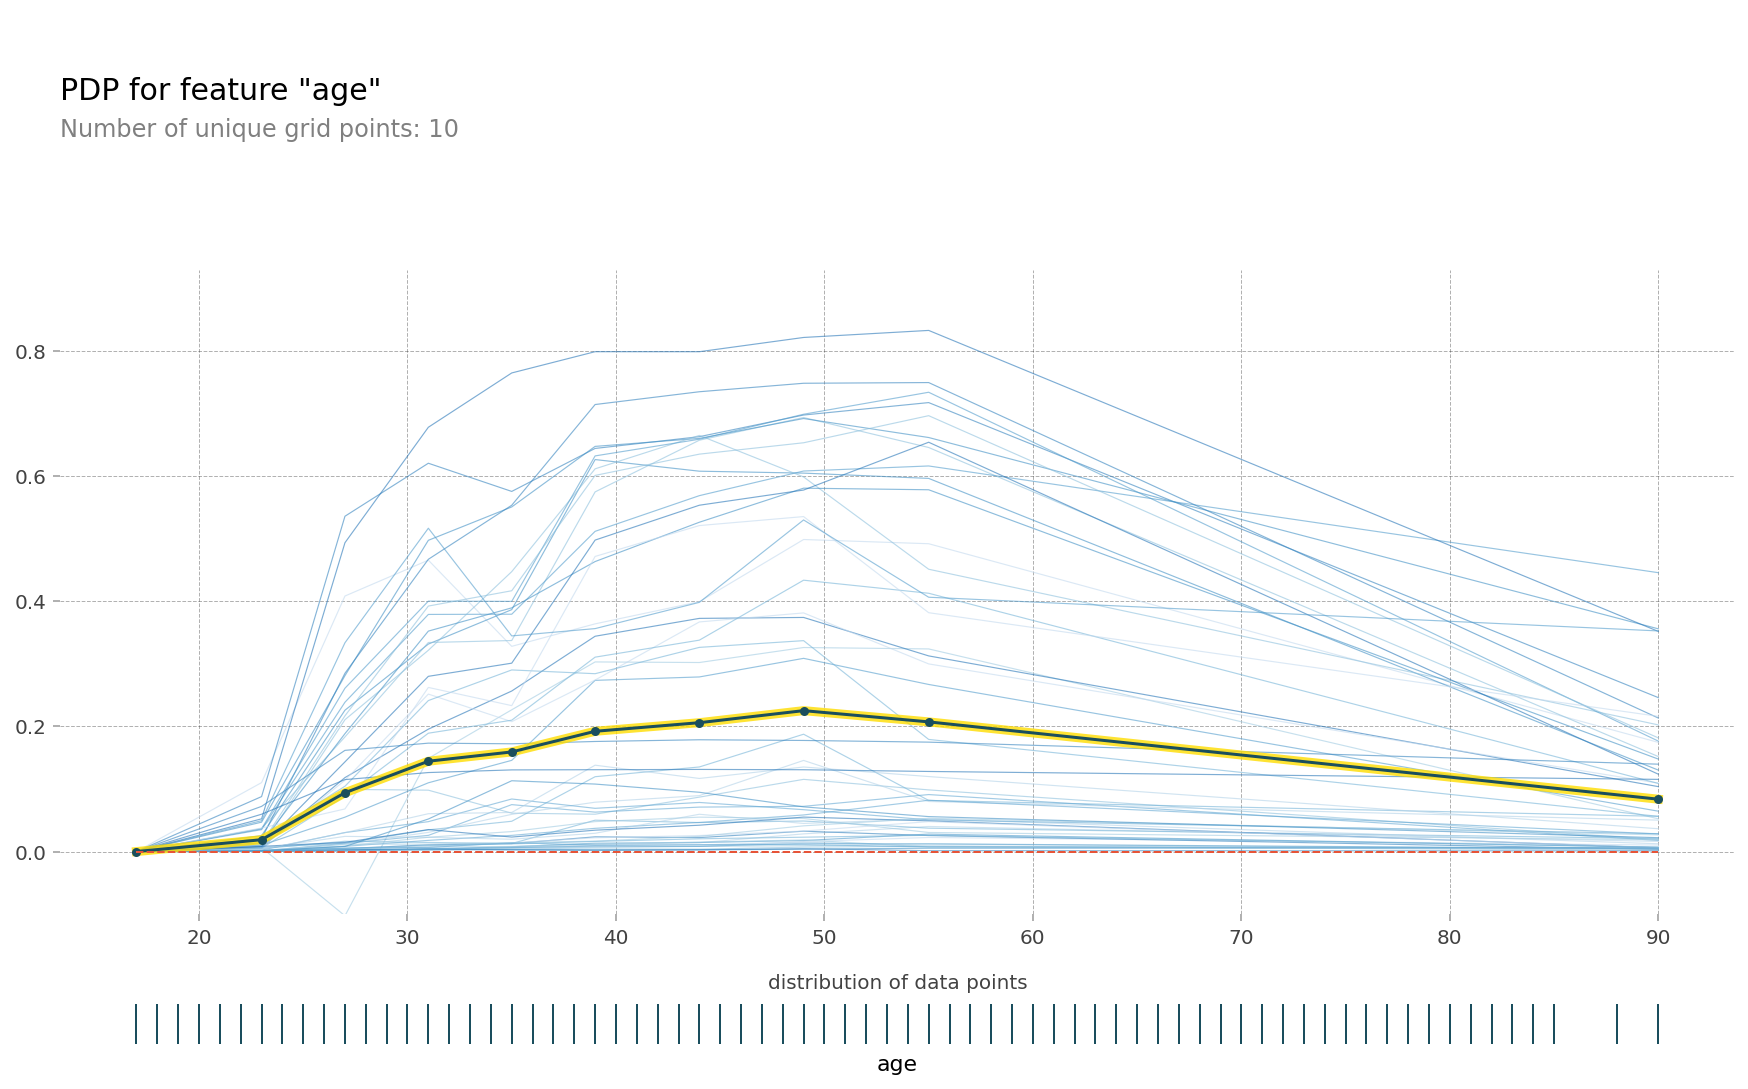

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,   # 각 data의 분포를 확인할 것인가
)

- 위와 같이, PDP는 ICE plot을 평균냄으로써 모델의 전반적인 특성에 대한 이해를 확인할 수 있게 해 줍니다.
- 데이터의 분포가 없는 80-90대 의 경우 해석할 때 유의해야한다.
- [여기](https://twitter.com/i/status/1066398522608635904) gif를 참고하여 PDP와 ICE plot간의 관계를 다시 한 번 확인해 보세요!


### 2개 특성의 변화에 대한 PDP도 그려봅시다.

- 2특성 변화에 대한 PDP는 heatmap 형태로 시각화할 수 있습니다.

---
(참고: PDPBox version <= 0.20 과 몇몇 matplotlib 버전에서 `pdp_interact_plot`에서`plot_type='contour'` 설정시 에러가 발생할 수 있습니다.
`TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'`
다음 링크를 확인해 주세요 https://github.com/SauceCat/PDPbox/issues/40)



In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
target_features = ["age", "hours-per-week"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=target_features,
)

(<Figure size 1080x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6990bc1550>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6990c0a370>})

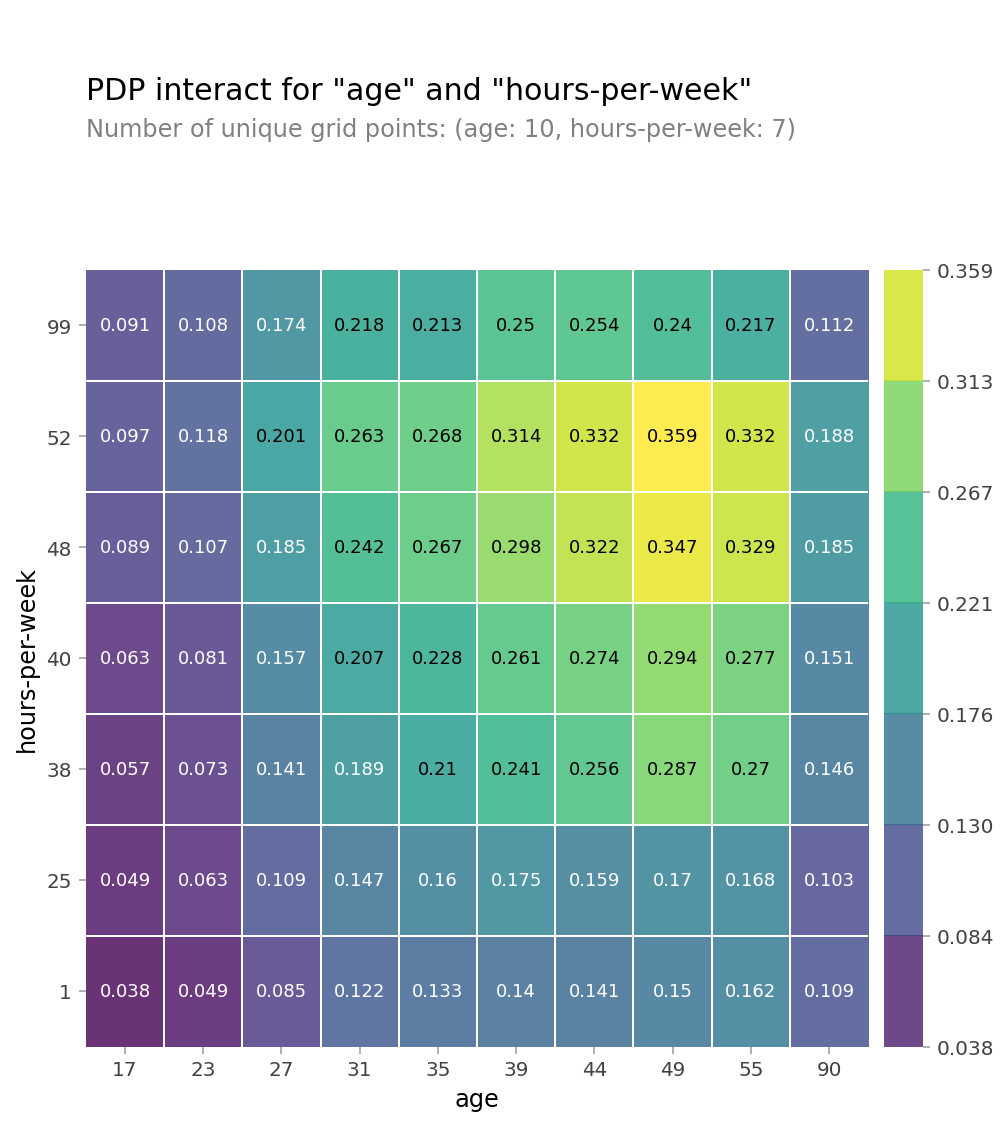

In [ ]:
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)

In [ ]:
# 하나의 특성을 그렸을때는 변화량
# 여기서는 예측확률값 자체를 나타냄

- `plotly` 라이브러리를 사용해 3D 형태로 시각화할 수도 있습니다.

In [ ]:
# 2D PDP dataframe
interaction.pdp

,age,hours-per-week,preds
0,17.0,1.0,0.038172
1,17.0,25.0,0.049292
2,17.0,38.0,0.056605
3,17.0,40.0,0.063273
4,17.0,48.0,0.089064
...,...,...,...
65,90.0,38.0,0.145927
66,90.0,40.0,0.151213
67,90.0,48.0,0.184539
68,90.0,52.0,0.188355


In [ ]:
# 위에서 만든 2D PDP 데이터를 pivoting합니다.

pdp_pivoted_data = interaction.pdp.pivot_table(
    values="preds", columns=target_features[0], index=target_features[1]
)[
    ::-1
]  # 인덱스를 역순으로 만드는 slicing입니다

In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp_pivoted_data.columns, y=pdp_pivoted_data.index, z=pdp_pivoted_data.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=target_features[0]),
        yaxis=dict(title=target_features[1]),
        zaxis=dict(title=target),
    )
)

fig = go.Figure(surface, layout)
fig.show()

### 범주형 특성에 대해서도 PDP를 그려볼 수 있습니다.
- 범주형 특성은 학습 시 인코딩되어 수치형으로 변환됩니다. 
- 수치형으로 변환되기 전의 각 범주 값을 PDP에 제공하여 이해하기 쉬운 형태로 시각화해 봅시다.

In [ ]:
target_feature = "marital-status"

In [ ]:
# 학습 시 사용한 encoder로부터 각 특성값들을 어떤 수치값으로 매핑했는지 확인할 수 있습니다.
mappings = encoder.mapping
print(mappings)

[{'col': 'workclass', 'mapping':  Self-emp-not-inc    1
 Private             2
 Federal-gov         3
 State-gov           4
 Local-gov           5
 Self-emp-inc        6
 Without-pay         7
NaN                 -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'education', 'mapping':  9th              1
 Bachelors        2
 Some-college     3
 10th             4
 HS-grad          5
 Masters          6
 Assoc-voc        7
 1st-4th          8
 Preschool        9
 Assoc-acdm      10
 Prof-school     11
 11th            12
 7th-8th         13
 Doctorate       14
 5th-6th         15
 12th            16
NaN              -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'marital-status', 'mapping':  Married-civ-spouse       1
 Widowed                  2
 Divorced                 3
 Never-married            4
 Separated                5
 Married-spouse-absent    6
 Married-AF-spouse        7
NaN                      -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'occupation', 'mapping

In [ ]:
# mappings에서 우리가 보고자 하는 타겟 특성의 mapping을 꺼내 옵시다.
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
print(mapping_data)

[{'col': 'marital-status', 'mapping':  Married-civ-spouse       1
 Widowed                  2
 Divorced                 3
 Never-married            4
 Separated                5
 Married-spouse-absent    6
 Married-AF-spouse        7
NaN                      -2
dtype: int64, 'data_type': dtype('O')}]


In [ ]:
# mapping은 pandas series 형태로 저장되어 있습니다. index가 원래 값이고, value가 인코딩된 수치형 값입니다.
maps = mapping_data[0]["mapping"]
print(type(maps))
print(maps)

<class 'pandas.core.series.Series'>
 Married-civ-spouse       1
 Widowed                  2
 Divorced                 3
 Never-married            4
 Separated                5
 Married-spouse-absent    6
 Married-AF-spouse        7
NaN                      -2
dtype: int64


(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f69905d8eb0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f69905dd6a0>})

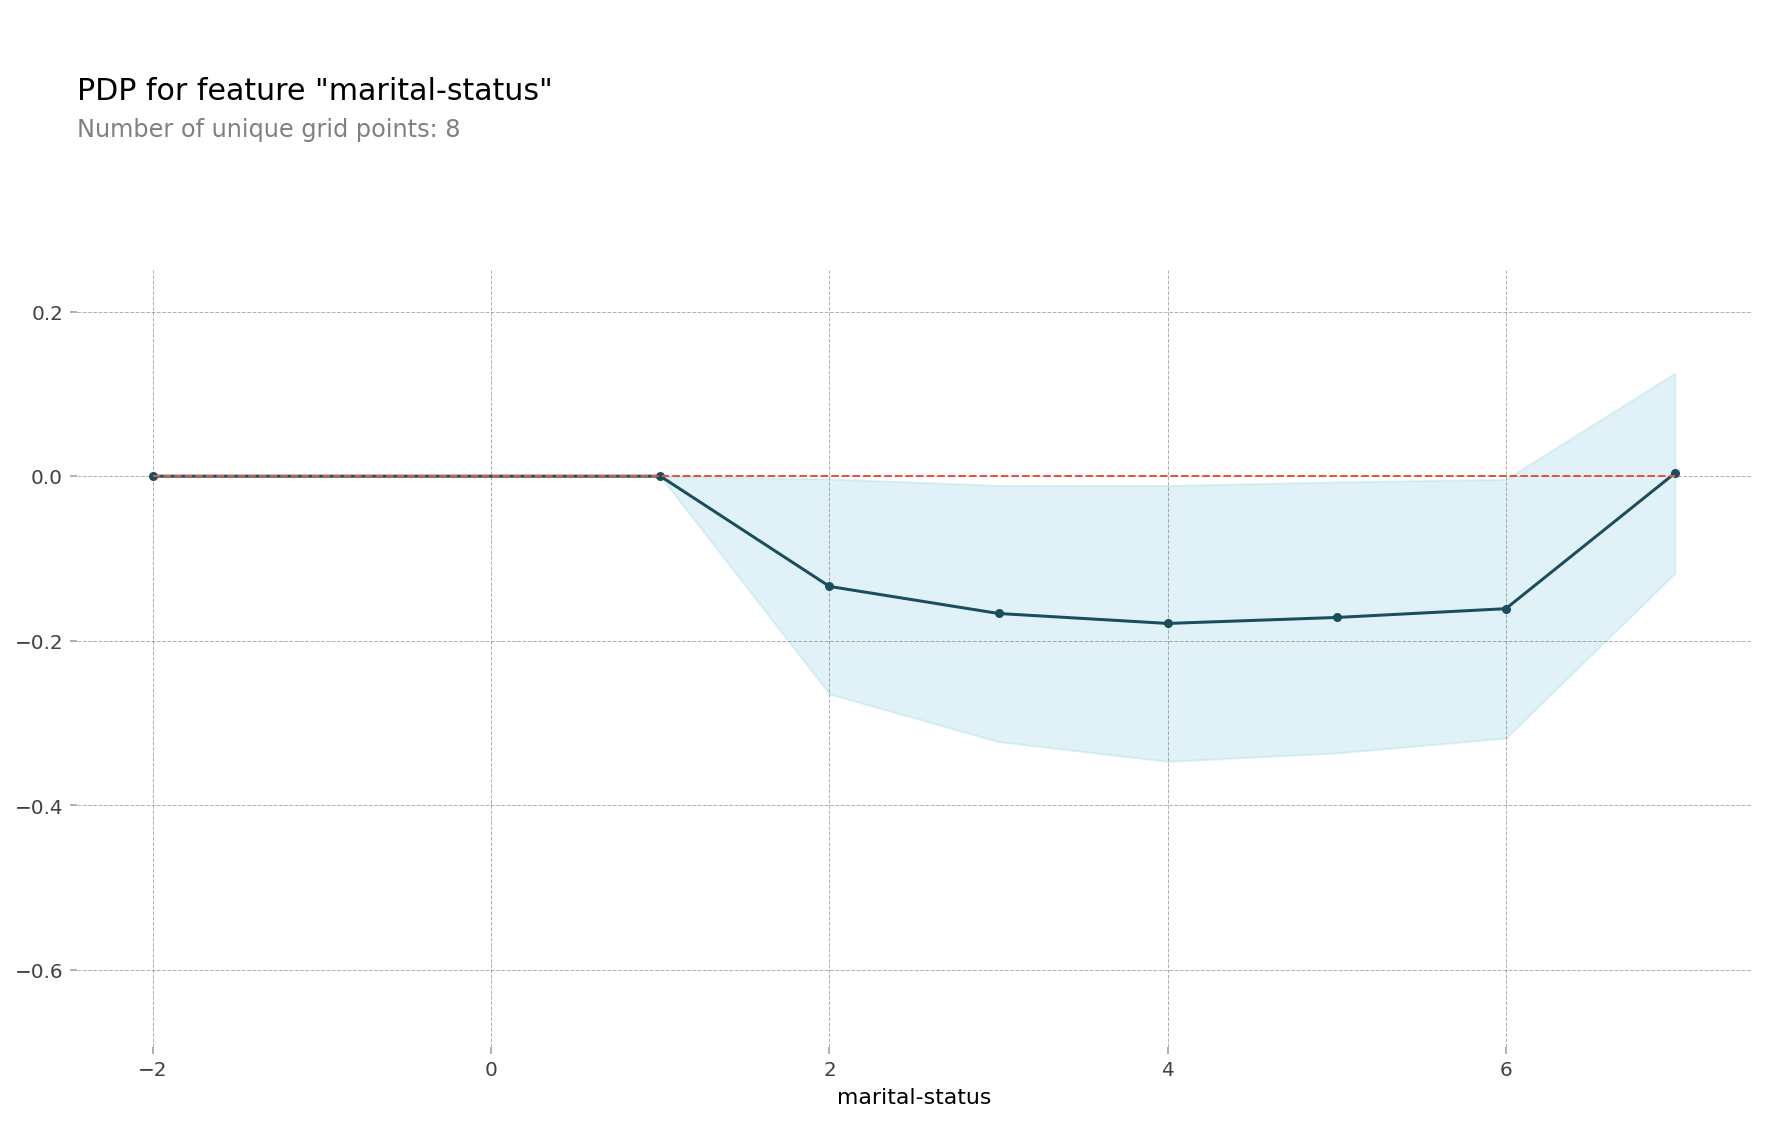

In [ ]:
# 우선 인코딩된 후의 값을 기준으로 PDP를 그려 봅시다.
pdp_dist = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4, 5, 6, 7],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)
pdp_plot(pdp_dist, target_feature)  # 인코딩된 marital-status 값을 확인할 수 있습니다

In [ ]:
# 인코딩된 특성값과 원래 특성값을 리스트로 가져옵니다.
encoded_features = maps.values.tolist()
original_features = maps.index.tolist()
print(encoded_features, original_features)

[1, 2, 3, 4, 5, 6, 7, -2] [' Married-civ-spouse', ' Widowed', ' Divorced', ' Never-married', ' Separated', ' Married-spouse-absent', ' Married-AF-spouse', nan]


([<matplotlib.axis.XTick at 0x7f699055b2e0>,
 [Text(0, 0, ' Married-civ-spouse'),
  Text(0, 0, ' Widowed'),
  Text(0, 0, ' Divorced'),
  Text(0, 0, ' Never-married'),
  Text(0, 0, ' Separated'),
  Text(0, 0, ' Married-spouse-absent'),
  Text(0, 0, ' Married-AF-spouse'),
  Text(0, 0, 'nan')])

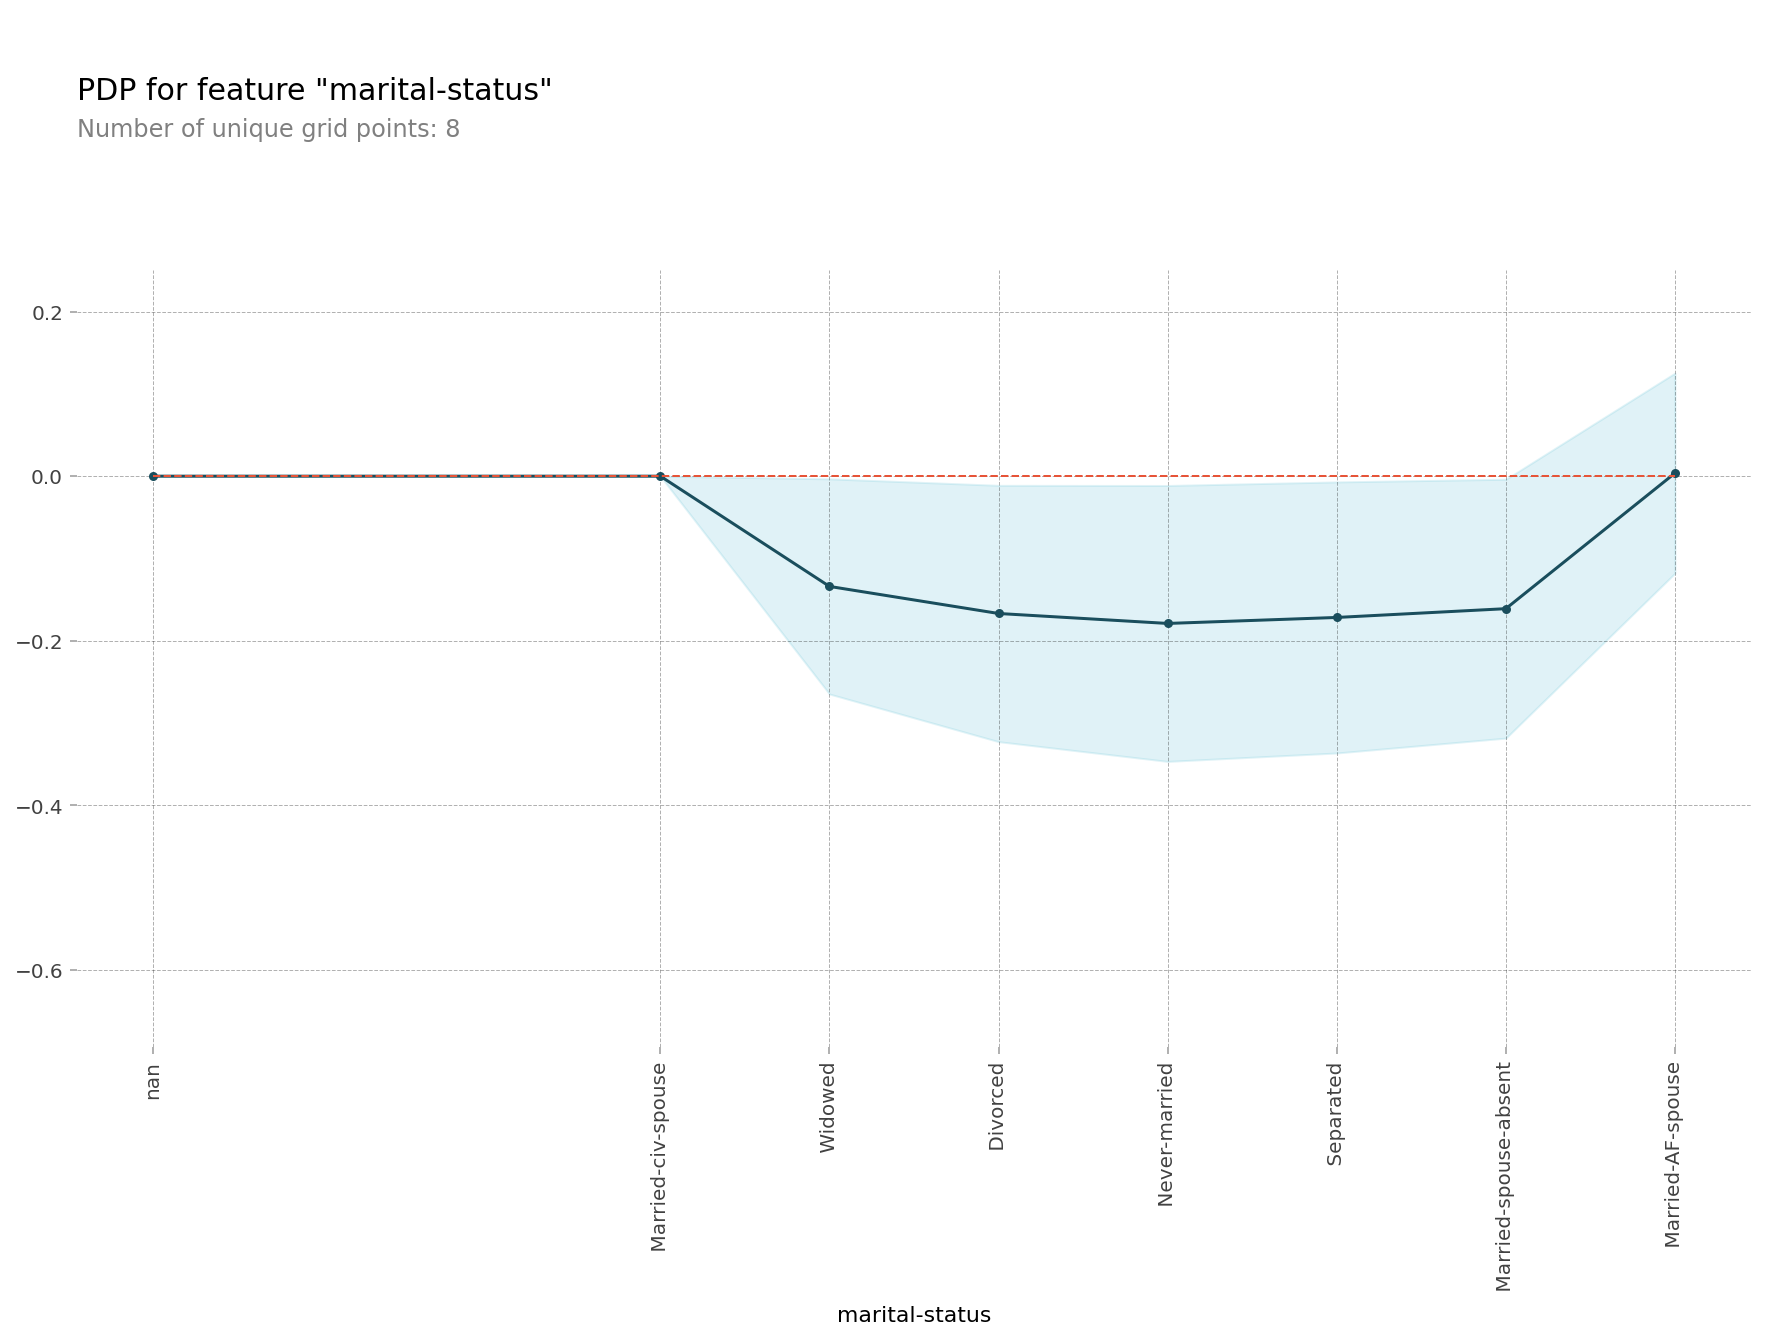

In [ ]:
pdp_plot(pdp_dist, target_feature)

# plot의 x축에 표시될 값을 encoded features에서 original features로 매핑해 줍니다.
plt.xticks(encoded_features, original_features, rotation=90)

### 2특성 PDP도 그려 볼까요?

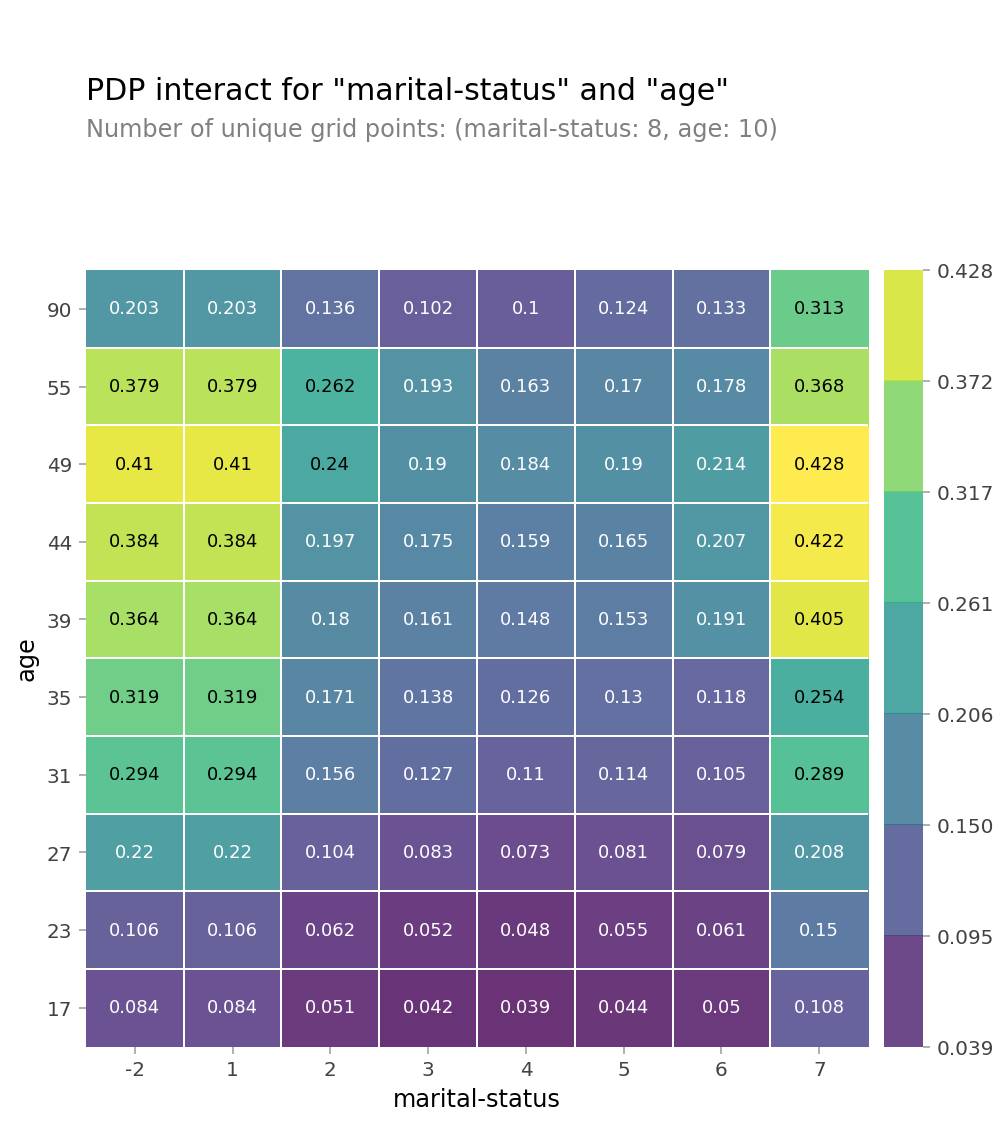

In [ ]:
target_features = ["marital-status", "age"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
    cust_grid_points=[
        [-2, 1, 2, 3, 4, 5, 6, 7],  # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
        None,  # 두 번째 특성인 age에 대해서는 자동 생성되는 grid point를 사용합니다.
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
# plot_params={'xticks':[encoded_features, original_features]}

Text(0.5, 1.0, "PDP of ['marital-status', 'age'], decoded categorical")

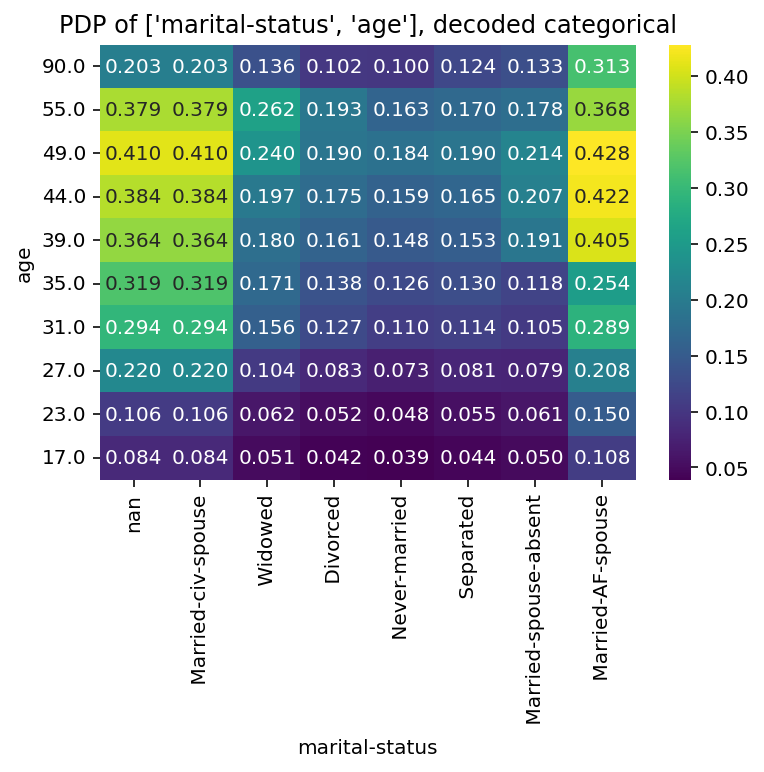

In [ ]:
import seaborn as sns

pdp_pivoted_data = interaction.pdp.pivot_table(
    values="preds", columns=target_features[0], index=target_features[1]
)[::-1]

# pdp_pivoted_data DataFrame의 columndms categorical인 marital-status입니다. column을 rename합시다.
pdp_pivoted_data.rename(
    columns=dict(zip(encoded_features, original_features)), inplace=True
)
sns.heatmap(data=pdp_pivoted_data, annot=True, fmt=".3f", cmap="viridis")
plt.title(f"PDP of {target_features}, decoded categorical")

# 3. ML 모델의 해석 - 정리
- 두 노트에 걸쳐 여러 ML 모델 해석법을 학습했습니다.
- 지금까지 배운 해석 방법들은 각기 다른 특성을 지니며, 크게 두 가지 기준으로 분류할 수 있습니다.

## Model-Specific vs Model-Agnostic

- Model-Specific ML 해석법은 사용하는 모델에 종속적이지만, Model-Agnostic 방법들은 모든 모델에 범용적으로 적용 가능합니다.

### Model-Specific
- **선형 모델의 coefficient를 다시 떠올려 봅시다.**
$$ HousePrice = \beta_0 + \beta_1 * LocInSeoul + \beta_2 * HouseSize + \beta_3 * isOver10YrOld + ... $$ 
- coefficient는 선형 모델의 parameter인 동시에 모델이 각 특성을 어떻게 이해하고 해석하는지를 보여주는 값이기도 합니다. 우리는 각 $\beta$ 값으로부터 각 특성의 중요도, 특성과 예측값의 상관관계 등을 쉽게 파악할 수 있습니다.

- **트리 모델에서도 몇 가지 방법을 사용해 모델을 해석할 수 있습니다.**

<img src=https://i.imgur.com/8IyZ8gT.png width=800>

- 위 시각화로부터 트리 모델이 데이터를 각 분기 단계에서 어떻게 이해하는지를 파악할 수 있습니다(하지만 트리 깊이가 깊어질수록 해석이 매우 어려워집니다).
- Mean decrease impurity Feature Importance 값을 통해 트리 모델에서의 특성 중요도도 파악할 수 있습니다.

- **하지만 위 방법들은 우리가 사용한 모델에 종속적입니다.** 이 방법들은 별도 과정 없이 손쉽게 사용할 수 있지만, 서로 다른 모델이 각기 특성을 어떻게 이해하고 있는지를 비교해 보기는 어렵습니다.
- 그리고 위와 같이 해석 가능한 범주에 있는 모델들은 대개 모델이 복잡하지 않고 낮은 성능을 보입니다. 위와 같은 방법을 사용하기 위해 굉장히 제한적인 범주의 모델을 사용할 수밖에 없습니다.


### Model-Agnostic
- 하지만 동일한 문제를 해결할 수 있는 모델은 굉장히 다양합니다. 일반적으로 하나의 문제를 해결할 때 여러 모델로 데이터를 학습시킨 후 성능과 모델의 특성을 비교하게 됩니다.
- 여러 형태의 모델들을 동일한 해석 방법을 사용해 해석하고 서로 비교해 봄으로써 우리는 모델의 성능 차이, 예측 양상의 차이 등을 이해할 수 있게 됩니다.
- 우리가 배운 Drop-Column Importance, Permutation Importance, ICE plot, PDP 등은 **어느 모델에서나 적용할 수 있는 범용적인 해석법**입니다. 이를 Model-Agnostic하다고 합니다.
- Model-Agnostic한 해석법을 사용할 경우 머신러닝 개발자는 문제 해결을 위해 제한 없이 다양한 모델을 시도해볼 수 있으며, 이들을 나란히 놓고 비교해볼 수 있습니다.

## Global vs Local

- Global한 방법들은 모델의 평균적인 작동 양상을 설명하며, Local한 방법들은 특정 데이터 조건에서 모델의 반응을 보여줍니다.

### Global Methods
- 모델의 평균적인 예측 양상을 해석할 수 있는 여러 방법들이 있습니다.
- Permutation Importance, PDP 등은 각 특성의 변화에 따른 모델 예측의 평균적인 변화를 보여줍니다.
- 이런 방법들을 Global한 모델 해석법이라고 합니다.
- Global한 방법을 사용하면 큰 틀에서 모델의 작동을 이해하기 쉬운 형태로 해석할 수 있습니다. 하지만 대부분의 경우에서 Global한 방법들은 각 특성 간의 독립성을 가정하므로, 특성 간 상관관계가 강할 경우 해석이 틀릴 수 있습니다.

### Local Methods
- Global Methods와 달리, ICE plot은 데이터셋에서의 특정 관측치에 대한 모델의 예측 양상 변화를 보여줍니다. 이런 방법들을 Local한 모델 해석법이라고 합니다.
- Local한 방법을 사용하면 모델의 일반적인 상황에서의 예측을 손쉽게 이해하기는 어렵지만, 특성 간의 상관관계를 파악하거나 모델의 비정상적인 예측 패턴 등을 파악할 수 있습니다.

### Summary
- 지금까지 학습한 모델 해석법을 위 기준에 따라 분류해 봅시다.

|      | **Global** | **Local**|
|:----:|:------:|:----:|
|**Model-Specific**| (DT) Feature Importance, (Linear) Coefficient, ... | - |
|**Model-Agnostic**| Drop-Column/Permutation Importance, PDP, ... | ICE plot, ...|

## 👏 마무리
#### 이번 노트에서는 
- 특성이 모델에 어떻게 영향을 미치는지를 알 수 있는 ICE Plot과 PDP를 배웠습니다. 
- 모델을 해석할 수 있는 범위에 따른 모델 해석 방법을 분류해보았습니다. 
<br></br>

#### 학습 후 아래 질문에 답해보세요

1. ICE Plot은 무엇을 설명하는 방법인가요?
2. ICE Plot과 PDP의 차이는 무엇인가요?
3. PDP를 해석할 때 유의해야하는 것은 무엇인가요?
4. 모델을 해석할 수 있는 범위에 따라 모델 해석 방법을 어떻게 분류할 수 있나요?


# References
### Interpretable Machine Learning
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

### PDPbox
- [PDPbox library documentation](https://pdpbox.readthedocs.io/en/latest/)
- [PDP Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html#pdpbox-pdp-pdp-isolate)
- [pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html#pdpbox-pdp-pdp-plot)
- [pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html#pdpbox-pdp-pdp-interact)
- [pdpbox.pdp.pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html#pdpbox-pdp-pdp-interact-plot)
